In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!ls ../input/recruit-restaurant-visitor-forecasting -al

ls: cannot access '../input/recruit-restaurant-visitor-forecasting': No such file or directory


- 참고자료: [unzip file not matched 오류가 나는 이유](https://sancs.tistory.com/5)

In [3]:
!unzip ../input/recruit-restaurant-visitor-forecasting/\*.zip

unzip:  cannot find or open ../input/recruit-restaurant-visitor-forecasting/*.zip, ../input/recruit-restaurant-visitor-forecasting/*.zip.zip or ../input/recruit-restaurant-visitor-forecasting/*.zip.ZIP.

No zipfiles found.


# 🤔 그 날, 얼마나 많은 사람들이 우리 가게에 올까 ?

# DATA: [Recruit Restaurant Visitor Forecasting Data](https://www.kaggle.com/anvesh525/recruit-restaurant-visitor-forecasting-data)
기존의 데이터(AIR, HPG, 연결)와 추가 데이터(Weather)가 있다.
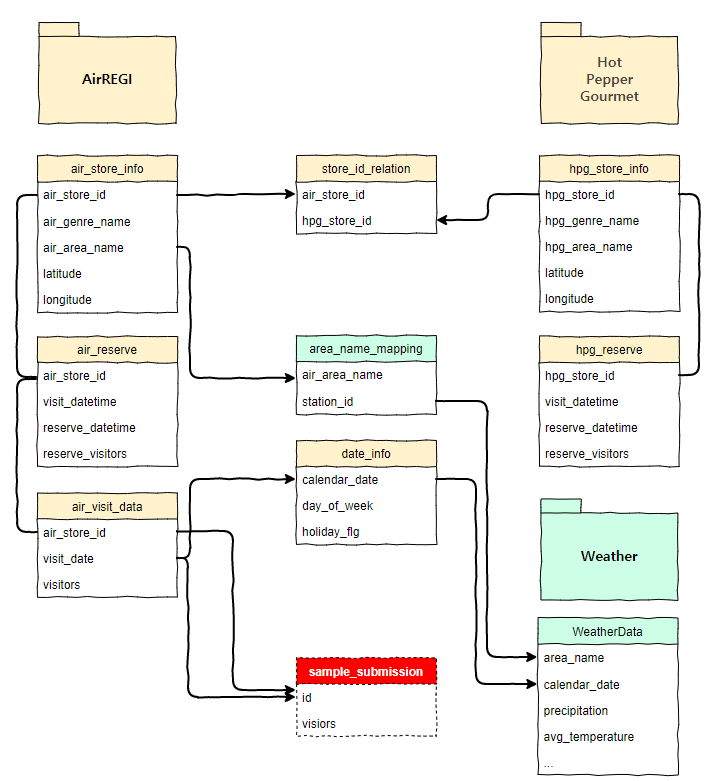

- [목표]
  - 주어진 데이터를 조합하여 최대의 정보를 포함한 **train**과 **test** 테이블을 만들어내자!
  
  
- [주어진 것]
  - 기존의 데이터: air사이트와 hpg사이트로 부터 얻은 두 부류의 데이터가 주어진다.
      - air 데이터
        - air_reserve.csv : 인터넷으로 예약한 사람들, 시간별!
        - air_store_info.csv
        - air_visit_data.csv : 실제로 가게에 방문한 사람들, 일자별 visitors
      - hpg 데이터
        - hpg_reserve.csv
        - hpg_store_info.csv
      - 연결 데이터
        - store_id_relation.csv
      - 기타 데이터
        - date_info.csv

  - 추가 데이터 : 이름과 지역을 매핑한 데이터와 날씨 정보(일본 정부 사이트?)가 주어진다.
     - area_name_mapping.csv
     - weatherData.csv

In [4]:
import glob, re
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
from xgboost import XGBRegressor
import lightgbm as lgb

In [5]:
# !ls ../input/recruit-restaurant-visitor-forecasting-data

In [6]:
data = {
    'tra': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/air_visit_data.csv'),
    'as': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/air_store_info.csv'),
    'hs': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/hpg_store_info.csv'),
    'ar': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/air_reserve.csv'),
    'hr': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/hpg_reserve.csv'),
    'id': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/store_id_relation.csv'),
    'tes': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/sample_submission.csv'),
    'hol': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/date_info.csv').rename(columns={'calendar_date':'visit_date'}),
    'wd': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/WeatherData.csv'),
    'anm': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/area_name_mapping.csv')
}

# EDA

## 0. 전체 데이터 살펴보기
- wd 데이터를 제외하고는 missing 데이터가 없음을 알 수 있다

In [7]:
from collections import OrderedDict
countdict = OrderedDict()
for key in data.keys(): 
    print(f'---------------------------------------------------------{key}---------------------------------------------------------')
    print(data[key].info())
    print(data[key].isnull().sum())
    countdict[key] = len(data[key])

---------------------------------------------------------tra---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   air_store_id  252108 non-null  object
 1   visit_date    252108 non-null  object
 2   visitors      252108 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.8+ MB
None
air_store_id    0
visit_date      0
visitors        0
dtype: int64
---------------------------------------------------------as---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   air_store_id    829 non-null    object 
 1   air_genre_name  829 non-null    object 
 2   air_area_name   829 non-null 

In [8]:
from pprint import pprint
pprint(countdict)

OrderedDict([('tra', 252108),
             ('as', 829),
             ('hs', 4690),
             ('ar', 92378),
             ('hr', 2000320),
             ('id', 150),
             ('tes', 32019),
             ('hol', 517),
             ('wd', 33088),
             ('anm', 103)])


In [9]:
for key in data.keys(): 
    print(f'---------------------------------------------------------{key}---------------------------------------------------------')
    print(data[key].head(1))

---------------------------------------------------------tra---------------------------------------------------------
           air_store_id  visit_date  visitors
0  air_ba937bf13d40fb24  2016-01-13        25
---------------------------------------------------------as---------------------------------------------------------
           air_store_id  air_genre_name                 air_area_name  \
0  air_0f0cdeee6c9bf3d7  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   

    latitude   longitude  
0  34.695124  135.197853  
---------------------------------------------------------hs---------------------------------------------------------
           hpg_store_id  hpg_genre_name                  hpg_area_name  \
0  hpg_6622b62385aec8bf  Japanese style  Tōkyō-to Setagaya-ku Taishidō   

    latitude   longitude  
0  35.643675  139.668221  
---------------------------------------------------------ar---------------------------------------------------------
           air_store_id       visit

# 🤓 데이터 다루기 순서
1. 개별 테이블 다루기
   - ar, hr: air_reserve, hr_reserve
   - tra: air_visit_data
   - hol: date_info
   - tes: Sample Submission
   
   
2. 테이블로 새로운 테이블 생성하기
   - tes: Sample에 필요한 Stores 테이블 생성
   - Stores에 store_data와 visit_date를 넣어줌
   - Store에 들어온 genre와 area를 라벨 인코딩 해줌


3. Test Train 테이블 생성하기
   - Sample Submission 에서 test를


## 개별 테이블 다듬기

## 1. hr(hpg_reserve)
  - air_store_id 기준으로 데이터를 분석하기 위해 `store_id_relation`을 활용해 hpg_reserve에 air_store_id를 추가한다

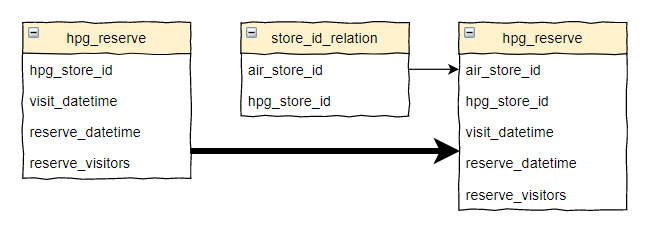

In [10]:
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

## 2. ar, hr: air/hpq_reserve 테이블
- info( ... ) method로 살펴본 결과 날짜형인 visit_datetime과 reverse_datetime이 object로 되어 있음
- datetime 라이브러리를 이용해 전처리 해주기로 함
  1. datetime형 자료를 변환 후 date(YYYY-MM-DD)만 추리기
  2. 새로운 feature인 reserve_datetime_diff 생성
  3. groupby로 air_store_id, visit_date, rs_sum, rv_sum, rs_mean, rv_mean 꼴로 테이블을 형성한다. [회고] groupby의 사용법을 확실하게 이해할 수 있었다
  
  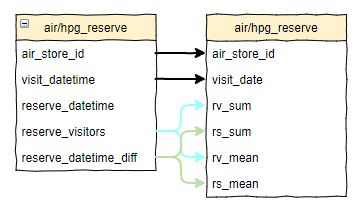
- 참고자료: [[파이썬 datetime] 일자와 시간(dt) 처리법](https://m.blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221603462366&proxyReferer=https:%2F%2Fwww.google.com%2F)

In [11]:
#TEST
# data['hr'].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum()
# .rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})    

In [12]:
for df in ['ar','hr']:
    #YYYY-MM-DD
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    
    #Feature Engineering: 방문하기까지 며칠이 걸렸을까
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)

    #air/hpg_reserve를 다시 만들어준다
    tmp1 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs_sum', 'reserve_visitors': 'rv_sum'})
    tmp2 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs_mean', 'reserve_visitors': 'rv_mean'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

In [13]:
for df in ['ar','hr']:
    print(data[df].head())

           air_store_id  visit_date  rs_sum  rv_sum  rs_mean  rv_mean
0  air_00a91d42b08b08d9  2016-10-31       0       2      0.0      2.0
1  air_00a91d42b08b08d9  2016-12-05       4       9      4.0      9.0
2  air_00a91d42b08b08d9  2016-12-14       6      18      6.0     18.0
3  air_00a91d42b08b08d9  2016-12-17       6       2      6.0      2.0
4  air_00a91d42b08b08d9  2016-12-20       2       4      2.0      4.0
           air_store_id  visit_date  rs_sum  rv_sum  rs_mean  rv_mean
0  air_00a91d42b08b08d9  2016-01-14       3       2      3.0      2.0
1  air_00a91d42b08b08d9  2016-01-15       6       4      6.0      4.0
2  air_00a91d42b08b08d9  2016-01-16       3       2      3.0      2.0
3  air_00a91d42b08b08d9  2016-01-22       3       2      3.0      2.0
4  air_00a91d42b08b08d9  2016-01-29       6       5      6.0      5.0


# 3. tra: air_visit_data 테이블
- [구성] air_store_id / visit_date / visitors
- visit_date feature를 datetime자료형으로 변환하고 dow, year, month, visit_date로 나눠준다

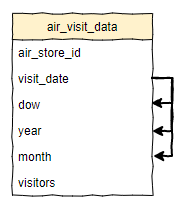

In [14]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])

In [15]:
#TEST ZONE
# data['tra']['visit_date'].dt.dayofweek
# data['tra']['visit_date'] # 2016-1-13 : 수요일 : 2 => 월요일: 0 
# data['hol']['day_of_week'] # 0번 인덱스: 금요일 => 금요일: 0

In [16]:
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

In [17]:
print(data['tra'].head())

           air_store_id  visit_date  visitors  dow  year  month
0  air_ba937bf13d40fb24  2016-01-13        25    2  2016      1
1  air_ba937bf13d40fb24  2016-01-14        32    3  2016      1
2  air_ba937bf13d40fb24  2016-01-15        29    4  2016      1
3  air_ba937bf13d40fb24  2016-01-16        22    5  2016      1
4  air_ba937bf13d40fb24  2016-01-18         6    0  2016      1


# 4. hol: date_info 테이블
- [구성] visit_date / day_of_week / holiday_flg

In [18]:
lbl = preprocessing.LabelEncoder()

data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date

data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])

- `hol`에서 LabelEncoder결과값 
  - array(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'], dtype=object)

In [19]:
lbl.classes_

array(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'], dtype=object)

In [20]:
print(data['hol'].head())

   visit_date  day_of_week  holiday_flg
0  2016-01-01            0            1
1  2016-01-02            2            1
2  2016-01-03            3            1
3  2016-01-04            1            0
4  2016-01-05            5            0


# 5. tes: sample_submission 테이블
- [구성] id / visitors
- `sample_submission`의 id에는 **air_store_id**와 **visit_date**의 정보가 함께 있으므로 분리해두자
- 분리한 **visit_date**를 datetime자료형으로 변환하고 **dow**, **year**, **month**, **visit_date**로 나눠준다
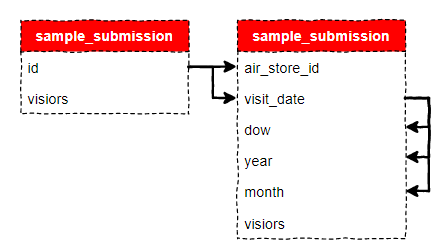

In [21]:
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])

data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

In [22]:
print(data['tes'].head())

                                id  visitors          air_store_id  \
0  air_00a91d42b08b08d9_2017-04-23         0  air_00a91d42b08b08d9   
1  air_00a91d42b08b08d9_2017-04-24         0  air_00a91d42b08b08d9   
2  air_00a91d42b08b08d9_2017-04-25         0  air_00a91d42b08b08d9   
3  air_00a91d42b08b08d9_2017-04-26         0  air_00a91d42b08b08d9   
4  air_00a91d42b08b08d9_2017-04-27         0  air_00a91d42b08b08d9   

   visit_date  dow  year  month  
0  2017-04-23    6  2017      4  
1  2017-04-24    0  2017      4  
2  2017-04-25    1  2017      4  
3  2017-04-26    2  2017      4  
4  2017-04-27    3  2017      4  


## 새로운 테이블 생성하기

## 1. tes: sample_submission 테이블 → stores 테이블
- 전체 데이터셋에서 주어진 상점의 수가 상당히 많으므로, 예측해야 하는 상점의 정보만 톱아보자

- [Trouble] 여기서 dow로 DataFrame을 뻥튀기 시킨 이유는?
  - 요일별 방문객 수가 큰 영향을 줄 것이라는 예측에 따른 가게의 요일별 방문객 수를 담기위한 그릇임
  


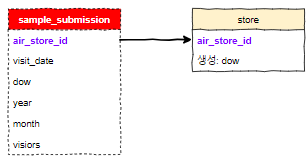

In [23]:
#Test
# unique_stores = data['tes']['air_store_id'].unique()
# print(unique_stores)
# [pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)]
# pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

In [24]:
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True)

## 1-1. Stores 테이블 += tra(air_visit_data) + as(air_store_info)

- `air_visit_data`에서 요일별 air_store_id의 min, mean, median, max 값을 구한 후 `stores`테이블에 있는 값의 경우 merge한다
> [Tips] `store`에 대한 부연설명을 하고 싶을 경우 merge로 left join해 주면 된다!

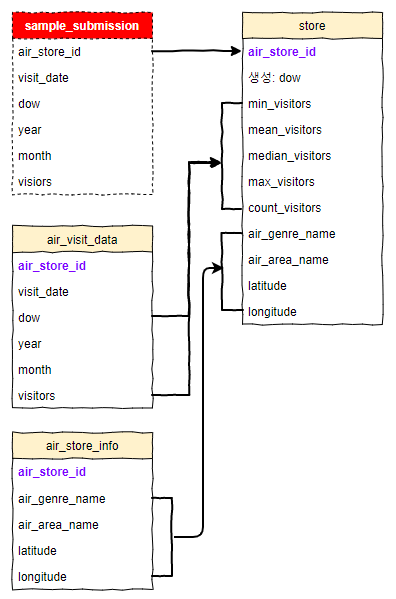

In [25]:
#Test
# data['tra'].groupby(['air_store_id', 'dow'], as_index = False)['visitors'].count()

In [26]:
#air_visit_data에서 요일 데이터를 가져와 store를 부연설명하자
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

#stores에 포함된 데이터들에 대한 store_info를 추가해준다
stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 

## 1-2. Stores 테이블 다듬기

1. `stores`의 air_genre_name, air_area_name에 대해 해당 문자열을 split한 후 새로운 컬럼에 담아 Label Encoding을 해 준다
  - 이때 10개의 컬럼으로 나누고 0을 패딩으로 사용한다
  - LabelEncoder는 Label Encoding을 해주는 기능을 가진 클래스로, fit 할 때마다 초기화되고 Label값이 업데이트 된다
    - 참고자료: [LabelEncoder](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=wideeyed&logNo=221592651246)
    - `apply` vs`map`: `apply`는 dataframe에서 row를 뽑아오고, `map`은 Series에서 element를 뽑아온다
      - 단, 단번에 처리한다!
    - 'Italian/French' → 'Italian French' → 'Italian', 'French' → 0, 0
   
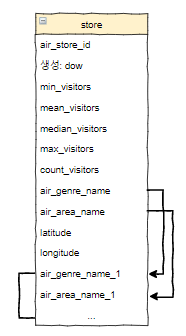

In [27]:
# NEW FEATURES FROM Georgii Vyshnia
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

# Train Test 테이블 생성하기

## 1. train, test 테이블 생성
- tra(`air_visit_data`)와 hol(`date_info`)테이블 병합하여 `train` 생성
  - dow와 days_of_week의 차이 ? dow는 월요일을 0으로 days_of_week는 금요일을 0으로 인코딩 돼 있음
- tes(`sample_submission`)와 hol(`date_info`)테이블 병합하여 `test` 생성

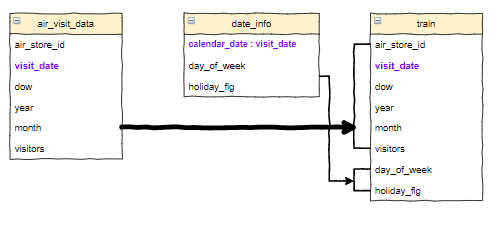
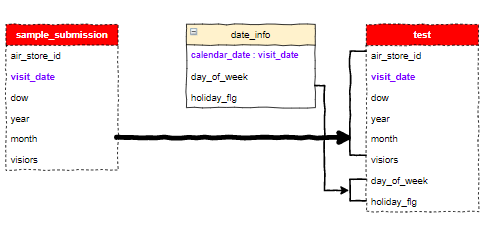

## 2. train과 test 테이블에 정리된 테이블 추가

- hol: date_info 테이블 추가

In [29]:
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 

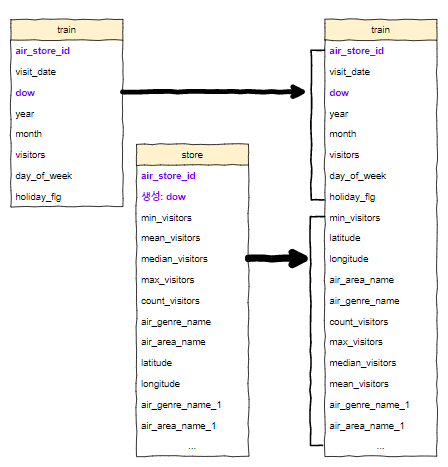
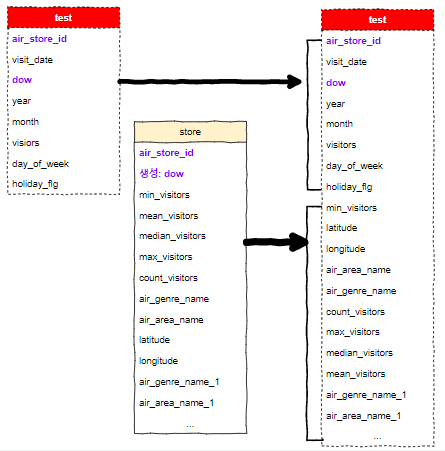

In [30]:
train = pd.merge(train, stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])

1. 왜 rv_sum rs_sum rv_mean rs_mean rv_sum rs_sum rv_mean rs_mean 이 아닌 rv_sum rs_sum rv_mean rs_mean 만 열로 만들어지는가
  - ~~[Trouble] 'hr'의 열만 포함되는 문제: 왜?? 돌면서 적용되는걸 테스트용으로 만들어서 적용x~~

- ar: air_reserve, hr: hpg_reserve 테이블 추가

In [31]:
for df in ['ar','hr']:
#     print('---------------------',df, '인데 대체 왜 !!')
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date'])
#     print(train.columns)
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])
#     print(test.columns)

## 3. train, test 테이블 다듬기

- air_store_id 와 visit_date를 합쳐서 원래의 id를 만들기

In [32]:
train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

- total_reserv_sum : 총 예약인원
- total_reserv_mean : 평균 예약인원
- total_reserv_dt_diff_mean : 예약과 방문까지의 평균기간

In [33]:
#(예약했다면) 몇명이 오겠다고 했는지
train['total_reserv_sum'] = train['rv_sum_x'] + train['rv_sum_y']
train['total_reserv_mean'] = (train['rv_mean_x'] + train['rv_mean_y']) / 2
#(예약했다면) 며칠이 걸려서 왔는지
train['total_reserv_dt_diff_mean'] = (train['rs_mean_x'] + train['rs_mean_y']) / 2

#(예약했다면) 몇명이 오겠다고 했는지
test['total_reserv_sum'] = test['rv_sum_x'] + test['rv_sum_y']
test['total_reserv_mean'] = (test['rv_mean_x'] + test['rv_mean_y']) / 2
#(예약했다면) 며칠이 걸려서 왔는지
test['total_reserv_dt_diff_mean'] = (test['rs_mean_x'] + test['rs_mean_y']) / 2

- 방문일자를 datetime자료형에서 수치형으로 변환
- 위도 경도의 offset
- 위도와 경도의 합

In [34]:
# 날짜를 수치형 데이터로 변환
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)

#위도 경도의 offset
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

# 위도 경도의 합
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

- store_id를 Label로 인코딩

In [36]:
lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

In [37]:
train

,air_store_id,visit_date,visitors,dow,year,month,day_of_week,holiday_flg,min_visitors,mean_visitors,...,rv_mean_y,id,total_reserv_sum,total_reserv_mean,total_reserv_dt_diff_mean,date_int,var_max_lat,var_max_long,lon_plus_lat,air_store_id2
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,6,0,7.0,23.843750,...,NaN,air_ba937bf13d40fb24_2016-01-13,NaN,NaN,NaN,20160113,8.362564,4.521799,175.409667,603
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,4,0,2.0,20.292308,...,NaN,air_ba937bf13d40fb24_2016-01-14,NaN,NaN,NaN,20160114,8.362564,4.521799,175.409667,603
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,0,0,4.0,34.738462,...,NaN,air_ba937bf13d40fb24_2016-01-15,NaN,NaN,NaN,20160115,8.362564,4.521799,175.409667,603
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,2,0,6.0,27.651515,...,NaN,air_ba937bf13d40fb24_2016-01-16,NaN,NaN,NaN,20160116,8.362564,4.521799,175.409667,603
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,1,0,2.0,13.754386,...,NaN,air_ba937bf13d40fb24_2016-01-18,NaN,NaN,NaN,20160118,8.362564,4.521799,175.409667,603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,1,2017,4,5,0,2.0,5.615385,...,NaN,air_24e8414b9b07decb_2017-04-18,NaN,NaN,NaN,20170418,8.367414,4.562362,175.364254,98
252104,air_24e8414b9b07decb,2017-04-19,6,2,2017,4,6,0,2.0,6.575000,...,NaN,air_24e8414b9b07decb_2017-04-19,NaN,NaN,NaN,20170419,8.367414,4.562362,175.364254,98
252105,air_24e8414b9b07decb,2017-04-20,7,3,2017,4,4,0,2.0,5.394737,...,NaN,air_24e8414b9b07decb_2017-04-20,NaN,NaN,NaN,20170420,8.367414,4.562362,175.364254,98
252106,air_24e8414b9b07decb,2017-04-21,8,4,2017,4,0,0,2.0,5.738095,...,NaN,air_24e8414b9b07decb_2017-04-21,NaN,NaN,NaN,20170421,8.367414,4.562362,175.364254,98


# 타겟 변수에 대한 간단한 시각화
- 오른쪽 꼬리가 긴 분포(right skewed)이므로 log변환해준다
  - 그럼 y가 어느정도 정규분포 가정을 만족한다
  - ~~[Trouble] countplot은 범주형 변수를 세는거야.. 실수하지말자..~~

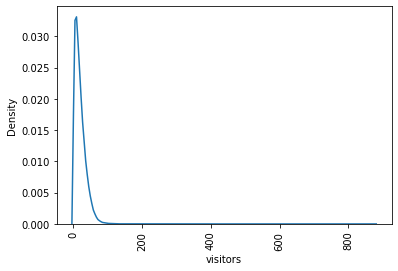

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(train['visitors'])
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:xlabel='visitors', ylabel='Density'>

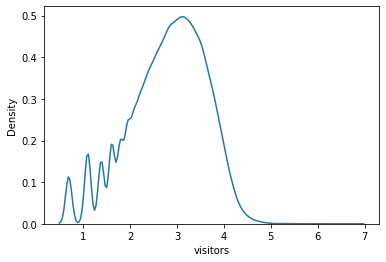

In [39]:
sns.kdeplot( np.log1p(train['visitors']) )

# Model Prediction & Evaluation

- 평가지표인 RMSLE를 계산하는 함수

In [40]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

- 범주형 변수와 target변수를 제외하고 모두 포함시킨다
  - [Trouble] -1로 놓는게 어떤 의미가 있지 ? 데이터에서 의미없는 값으로 추정됨!

In [41]:
col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
print(col)
train = train.fillna(-1) 
test = test.fillna(-1)

['dow', 'year', 'month', 'day_of_week', 'holiday_flg', 'min_visitors', 'mean_visitors', 'median_visitors', 'max_visitors', 'count_observations', 'air_genre_name', 'air_area_name', 'latitude', 'longitude', 'air_genre_name0', 'air_area_name0', 'air_genre_name1', 'air_area_name1', 'air_genre_name2', 'air_area_name2', 'air_genre_name3', 'air_area_name3', 'air_genre_name4', 'air_area_name4', 'air_genre_name5', 'air_area_name5', 'air_genre_name6', 'air_area_name6', 'air_genre_name7', 'air_area_name7', 'air_genre_name8', 'air_area_name8', 'air_genre_name9', 'air_area_name9', 'rs_sum_x', 'rv_sum_x', 'rs_mean_x', 'rv_mean_x', 'rs_sum_y', 'rv_sum_y', 'rs_mean_y', 'rv_mean_y', 'total_reserv_sum', 'total_reserv_mean', 'total_reserv_dt_diff_mean', 'date_int', 'var_max_lat', 'var_max_long', 'lon_plus_lat', 'air_store_id2']


- 앙상블 기법을 적용하기 위해 4가지 모델을 이용한다
  - GradientBoostingRegressor
  - KNeighborsRegressor
  - XGBRegressor
  - LGBMRegressor

- 참고자료: [xgboost GPU 사용하기](https://www.kaggle.com/vinhnguyen/accelerating-xgboost-with-gpu)

In [42]:
#200, 280, 280
for c in [100, 200, 300, 400, 500]:
    model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3, n_estimators=c, subsample=0.8, 
                          max_depth =10)
    model2 = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)
    model3 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=c, subsample=0.8, 
                          colsample_bytree=0.8, max_depth =12, tree_method = 'gpu_hist')
    model4 = lgb.LGBMRegressor(learning_rate=0.2, random_state=3, n_estimators=c, subsample=0.8, 
                          colsample_bytree=0.8, max_depth =12)
    
    model1.fit(train[col], np.log1p(train['visitors'].values))
    model2.fit(train[col], np.log1p(train['visitors'].values))
    model3.fit(train[col], np.log1p(train['visitors'].values))
    model4.fit(train[col], np.log1p(train['visitors'].values))

    preds1 = model1.predict(train[col])
    preds2 = model2.predict(train[col])
    preds3 = model3.predict(train[col])
    preds4 = model4.predict(train[col])
    
    print('RMSE GradientBoostingRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds1))
    print('RMSE KNeighborsRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds2))
    print('RMSE XGBRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds3))
    print('RMSE LGBMRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds4))

RMSE GradientBoostingRegressor:  0.40123113222263257
RMSE KNeighborsRegressor:  0.41945171611410526
RMSE XGBRegressor:  0.35152900138098675
RMSE LGBMRegressor:  0.4840822799942041
RMSE GradientBoostingRegressor:  0.3480211759737828
RMSE KNeighborsRegressor:  0.41945171611410526
RMSE XGBRegressor:  0.27241167727545645
RMSE LGBMRegressor:  0.47270764114362146
RMSE GradientBoostingRegressor:  0.30804382315588813
RMSE KNeighborsRegressor:  0.41945171611410526
RMSE XGBRegressor:  0.21466564475319447
RMSE LGBMRegressor:  0.4651567546823683
RMSE GradientBoostingRegressor:  0.2738262079341234
RMSE KNeighborsRegressor:  0.41945171611410526
RMSE XGBRegressor:  0.17309529047299888
RMSE LGBMRegressor:  0.45840584298982523
RMSE GradientBoostingRegressor:  0.24537144888235915
RMSE KNeighborsRegressor:  0.41945171611410526
RMSE XGBRegressor:  0.1410920807148871
RMSE LGBMRegressor:  0.45253662378129467


In [43]:
model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3, n_estimators=200, subsample=0.8, 
                      max_depth =10)
model2 = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)
model3 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=280, subsample=0.8, 
                      colsample_bytree=0.8, max_depth =12, tree_method = 'gpu_hist')
model4 = lgb.LGBMRegressor(learning_rate=0.2, random_state=3, n_estimators=280, subsample=0.8, 
                      colsample_bytree=0.8, max_depth =12)
model1.fit(train[col], np.log1p(train['visitors'].values))
model2.fit(train[col], np.log1p(train['visitors'].values))
model3.fit(train[col], np.log1p(train['visitors'].values))
model4.fit(train[col], np.log1p(train['visitors'].values))

preds1 = model1.predict(train[col])
preds2 = model2.predict(train[col])
preds3 = model3.predict(train[col])
preds4 = model4.predict(train[col])

print('RMSE GradientBoostingRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds1))
print('RMSE KNeighborsRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds2))
print('RMSE XGBRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds3))
print('RMSE LGBMRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds4))

RMSE GradientBoostingRegressor:  0.3480211759737828
RMSE KNeighborsRegressor:  0.41945171611410526
RMSE XGBRegressor:  0.22353260966610924
RMSE LGBMRegressor:  0.4666561090846041


In [58]:
model_list = [model1, model3, model4]
model_name_list = ['GradientBoostingRegressor', 'XGBRegressor', 'LGBMRegressor']
model_df = {}
for idx, model in enumerate(model_list, 1):
    model_df['model'+str(idx)] = pd.DataFrame({"var": col, "imp": model.feature_importances_})
    model_df['model'+str(idx)] = model_df['model'+str(idx)].sort_values(['imp'], ascending=False)

- 참고자료: [그래프 간 간격조절](https://steadiness-193.tistory.com/174)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


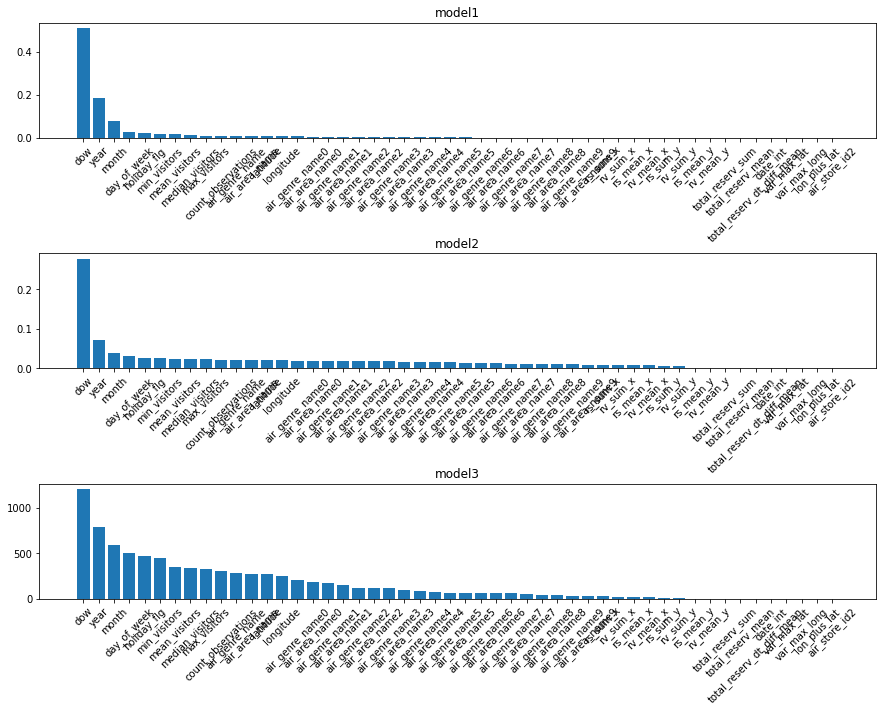

In [78]:
fig = plt.figure(figsize = (15, 10))
ax = fig.subplots(nrows=3, ncols=1)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=1)
plt.xticks(rotation=90)

i = 0
for name, df in model_df.items():
    ax.flatten()[i].bar(df['var'], df['imp'])
    ax.flatten()[i].set_title(name)
    ax.flatten()[i].set_xticklabels(col, rotation = 45)
    i += 1


- KEEP IT SIMPLE STUPID,`Bagging` 기법을 사용하기 위해 모델별 평균낸 값으로 예측치를 사용한다!

In [79]:
preds1 = model1.predict(test[col])
preds2 = model2.predict(test[col])
preds3 = model3.predict(test[col])
preds4 = model4.predict(test[col])

test['visitors'] = 0.25*preds1 + 0.25*preds2 + 0.25*preds3 + 0.25*preds4 
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
sub1 = test[['id','visitors']].copy()
sub1.to_csv('submission.csv', index=False)
del train; del data;

# [회고]
  - WeatherData를 구했으나 시간적 제약으로 인해 사용하지 못함